## Deep Learning Tumor detection project - Ibraheem Malik. 


To train this deep learning model I used the pytorch library. I wanted to make a model that classifies CRT scan images showing a healthy brain vs a brain that has a tumor. This project was done with the Pytorch library. Torchvision is useful for classification of pictures. We have 2 separate data folders where it collects the data. It takes a 3 channel image (RGB) and converts it to computer code. It is also trained using convolution layers, Relu, flatten, pool layers and Softmax to convert back. It is regularized using a learning rate of 3e-4 and accuracy is recorded with Negative Loss Likelihood Loss. By increasing the epochs, I saw a small increase in scores. A 0.96 accuracy score for both tumor recognition and healthy brain recognition. 

### 

### Import libraries

In [2]:
!pip install split-folders
!pip install torch_summary 
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install torchvision
!pip install pathlib
!pip install tqdm



  Using cached split_folders-0.5.1-py3-none-any.whl.metadata (6.2 kB)
Using cached split_folders-0.5.1-py3-none-any.whl (8.4 kB)
  Using cached torch_summary-1.4.5-py3-none-any.whl.metadata (18 kB)
Using cached torch_summary-1.4.5-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.3 MB/s  0:00:00
  Using cached pathlib-1.0.1-py3-none-any.whl.metadata (5.1 kB)
Using cached pathlib-1.0.1-py3-none-any.whl (14 kB)


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set(style="whitegrid")
import copy
import os
import torch   
from PIL import Image
import sys
!{sys.executable} -m pip install torchvision --upgrade --index-url https://download.pytorch.org/whl/cpu
import torchvision
from torchvision.transforms import transforms
from torchvision import utils
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
import pathlib 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
from tqdm import tqdm
from torch import optim

import warnings 
warnings.filterwarnings("ignore")




Looking in indexes: https://download.pytorch.org/whl/cpu


### Import data

In [4]:
df = pd.read_csv('brain_data/metadata.csv')
df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [5]:
# specify the path to the dataset
os.listdir('brain_data/Brain Tumor Data Set/Brain Tumor Data Set')

['Healthy', 'Brain Tumor']

In [6]:
df.shape

(4600, 6)

##### 4600 rows, 6 columns. The data is classified with a class of "tumor" or "normal".

In [7]:
df['class'].unique()

array(['tumor', 'normal'], dtype=object)

In [8]:
import sys
!{sys.executable} -m pip install split-folders
from splitfolders import ratio
import splitfolders

##### 4600 pictures in total. Data that we are using. 

In [9]:

data_dir = 'brain_data/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

#splitting datatset
splitfolders.ratio(data_dir, output='brain', seed = 20, ratio=(.8,.2))

#new path 
data_dir = 'brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:01, 3435.36 files/s]


In [ ]:
#transform images to code 
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.486, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]
)

In [ ]:
# make 2 new folders one to train data and one to validate data
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform = transform)
train_set.transform

val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform = transform)
val_set.transform


Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.486, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

### Let's plot some of the training data that we are using:

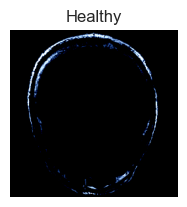

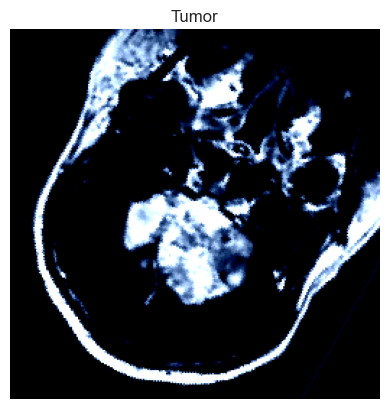

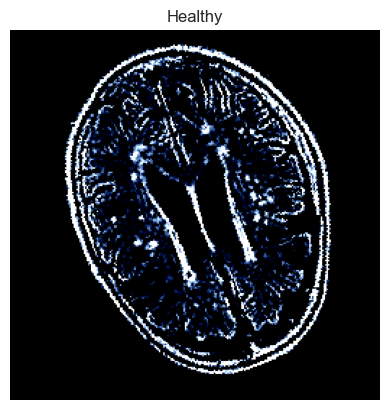

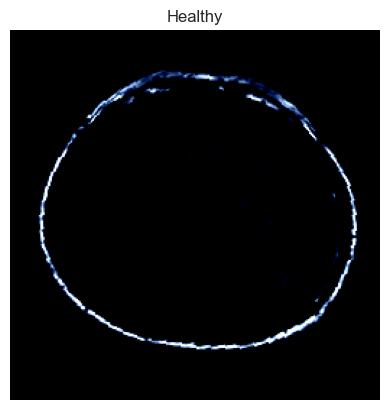

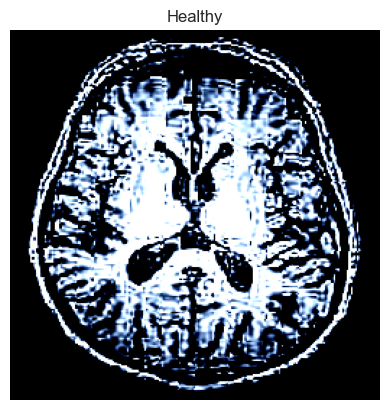

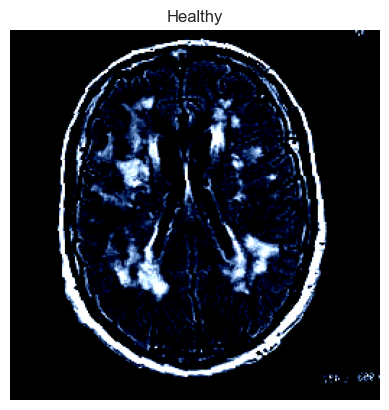

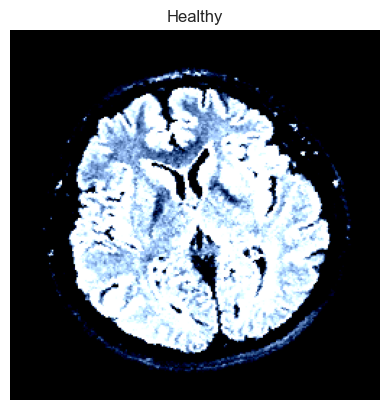

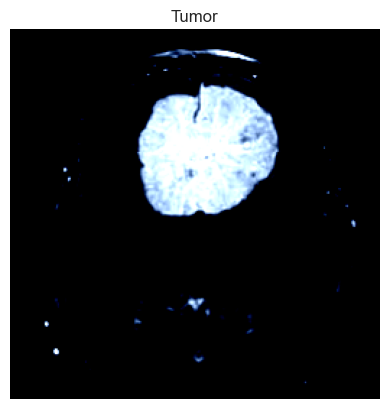

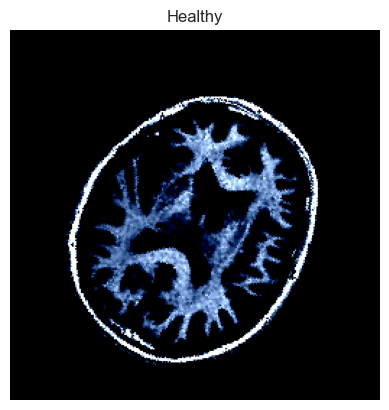

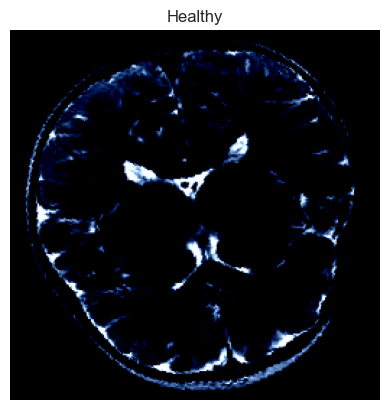

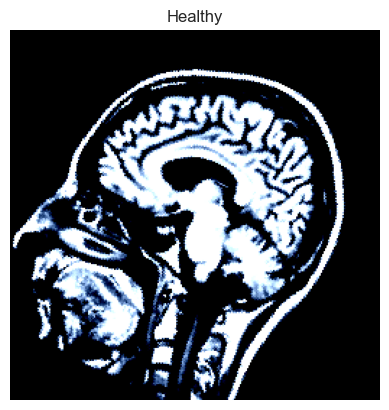

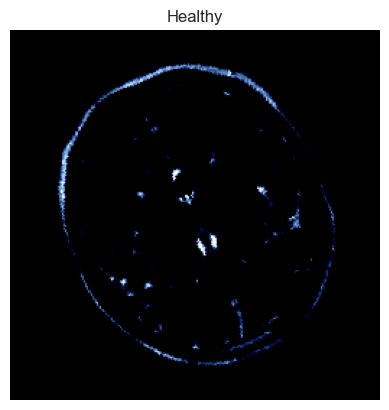

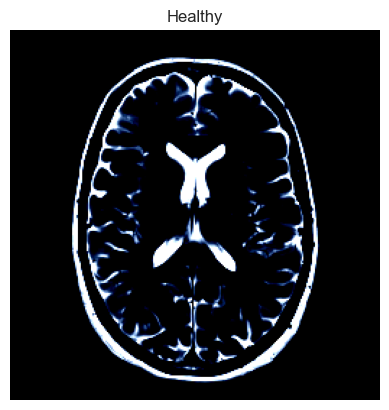

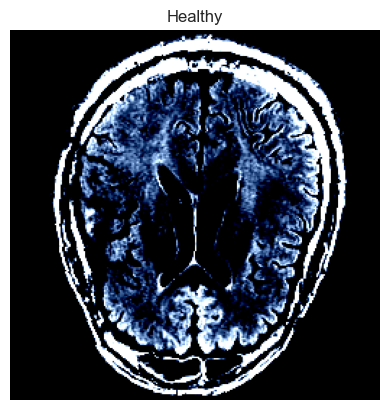

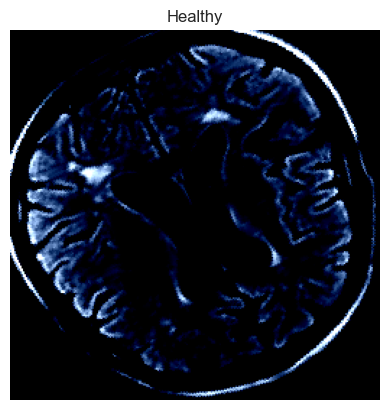

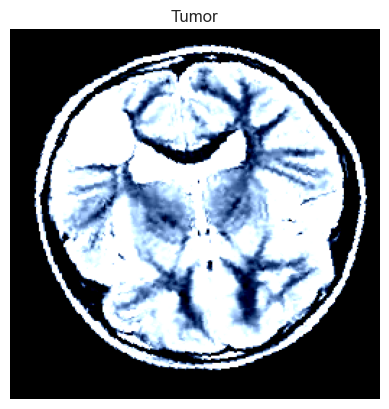

In [12]:
labels = {
    0: 'Tumor',
    1: 'Healthy'
}

fig = plt.figure(figsize=(10,10))
cols, rows = 4, 4 
for i in range (1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size =(1,)).item()
    img, label = train_set[sample_idx]
    fig.add_subplot(rows,cols,i)
    plt.title(labels[label])
    plt.axis('off')
    img_np = img.numpy().transpose((1,2,0))
    img_valid_range = np.clip(img_np,0,1)
    plt.imshow(img_valid_range)
    plt.show()

In [45]:
#batch 64 images
batch_size = 64

#load the data into code
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)

In [14]:
#print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y : {y.shape}")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y : torch.Size([64])
Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y : torch.Size([64])


##### The shape size of the image.

In [ ]:
# function to find output shape after conv2d layer
def findConv2DoutShape(H, W, conv, pool=2):
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    h_out = np.floor((H+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    w_out = np.floor((W +2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        h_out /= pool
        w_out /= pool
    return int(h_out), int(w_out)

In [ ]:
## function to build Deep Learning model

class CNN_Model(nn.Module): 
    def __init__(self,params):
        super(CNN_Model,self).__init__()
        C, H, W = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        #conv layers
        self.conv1 = nn.Conv2d(C, init_f, kernel_size=3)
        h,w = findConv2DoutShape(H,W,self.conv1)
        self.conv2 = nn.Conv2d(init_f, init_f*2, kernel_size=3)
        h,w = findConv2DoutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(init_f*2, init_f*4, kernel_size = 3)
        h,w = findConv2DoutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(init_f*4, init_f*8, kernel_size =3)
        h,w = findConv2DoutShape(h,w,self.conv4)
        self.flatten=h*w*init_f*8 #flatten the image
        self.fc1 = nn.Linear(self.flatten, num_fc1) #dense layer 1
        self.fc2 = nn.Linear(num_fc1, num_classes) #layer to predict classes

    #Relu layers & Pool layers
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, self.flatten)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, self.dropout_rate) #dropout layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) #output image layer



In [ ]:

#params for inputing into model
params_model = {
    "shape_in" : (3,256,256),
    "initial_filters": 8,
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2
}

model = CNN_Model(params_model)

In [19]:
%pip install torch_summary

Note: you may need to restart the kernel to use updated packages.


##### Summary of Deep Learning model:

In [20]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0

In [24]:
# run on GPU or else CPU, I am running this model locally on my computer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN_Model(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
#use Adam optimizer and learning rate scheduler
opt = optim.Adam(model.parameters(), lr = 3e-4)
lr_scheduler = ReduceLROnPlateau(optimizer = opt, mode = 'min', factor = 0.5, patience = 20)

In [46]:
#use negative log likelihood loss
loss_function = nn.NLLLoss(reduction = "sum")

In [ ]:
# Returns the learning rate of the first epoch
def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

In [ ]:
#function to record loss for each epoch. Returns (avg_loss, accuracy).
def loss_epoch(model, loss_func, dataloader, optimizer=None):
    running_loss = 0.0
    correct = 0
    total = 0
    if optimizer is not None:
        model.train()
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) #run on GPU or CPU
            optimizer.zero_grad() #clear gradients
            outputs = model(X)  # model returns log_probs
            loss = loss_func(outputs, y) # compute loss
            loss.backward() #backpropagate
            optimizer.step() # update weights
            running_loss += loss.item() #append loss
            preds = outputs.argmax(dim=1) # get predictions 
            correct += (preds == y).sum().item() # count correct predictions
            total += y.size(0) # total amount of samples 
    else:
        #if there is no optimizer, code will evaluate the model
        model.eval()
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = loss_func(outputs, y)
                running_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

    avg_loss = running_loss / max(1, len(dataloader)) #mean loss
    accuracy = correct / max(1, total) #accuracy for each epoch
    return avg_loss, accuracy 

In [ ]:
#function to train and validate the model
def Train_Val(model, params, verbose=False):

    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimizer"]
    train_d1 = params["train"]
    val_d1 = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]

    loss_history = {"train": [], "val": []}
    metric_history = {"train":[], "val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')


    for epoch in tqdm(range(epochs)):
        
        # Get the Learning Rate
        current_lr= get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        #train the model
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_d1, opt)

        #record loss and metric
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        #evaluate the model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func, val_d1)

            loss_history["val"].append(val_loss)
            metric_history["val"].append(val_metric)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a dict 
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("best model weights!")
        
        #learning rate scheduler step
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("loading best model weights!")
            model.load_state_dict(best_model_wts)

        if (verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

        #best model for weights
        model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history


In [ ]:
#params to train the model
params_train ={ 
    "train" : train_loader, 
    "val": val_loader,
    "epochs": 50,
    "optimizer": optim.Adam(model.parameters(), lr = 3e-4),
    "lr_change": ReduceLROnPlateau(optimizer = opt, mode = 'min', factor=0.5, patience = 20),
    "f_loss": nn.NLLLoss(reduction = "sum"),
    "weight_path": "best_model.pth"
}

model, loss_hist, metric_hist = Train_Val(model, params_train) #plug into the model.

100%|██████████| 50/50 [44:51<00:00, 53.84s/it]   


<Axes: >

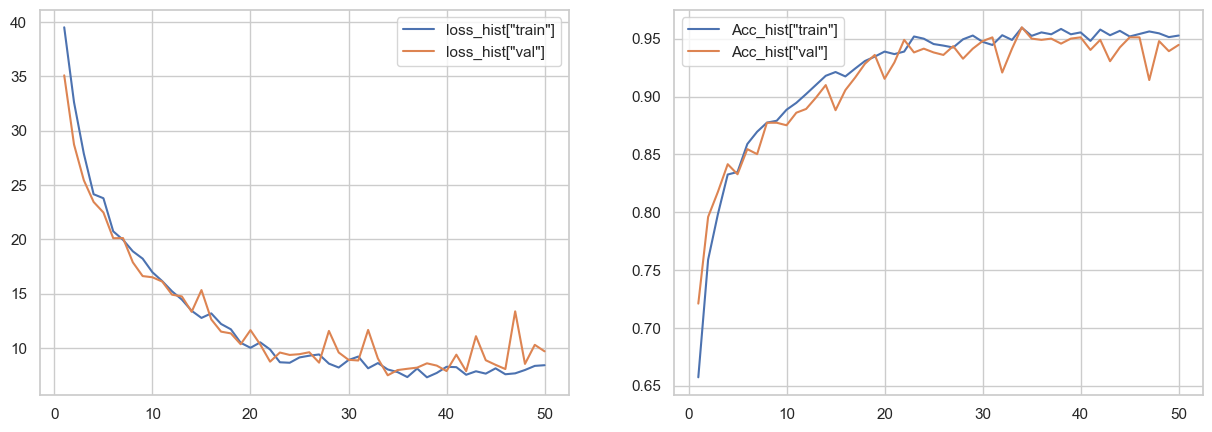

In [33]:
#plotting history 
epochs = params_train["epochs"]
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.lineplot(x=[*range(1,epochs+1)], y= loss_hist["train"], ax=ax[0], label = 'loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)], y=loss_hist["val"],ax =ax[0], label = 'loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)], y = metric_hist["train"], ax =ax[1], label = 'Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)], y = metric_hist["val"], ax =ax[1], label = 'Acc_hist["val"]')

##### I can see that the model is close to the validation set with this graph. Although, they're some bounces. 

In [37]:
def True_and_Pred(val_loader, model):
    i = 0 
    y_true = []
    y_pred = []

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred

#check confusion matrix for error analysis 
y_true, y_pred = True_and_Pred(val_loader, model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       503
         1.0       0.95      0.94      0.94       418

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921
 




##### The score are pretty good, but I want to try some more epochs. 

In [38]:
params_train ={ 
    "train" : train_loader, 
    "val": val_loader,
    "epochs": 100,
    "optimizer": optim.Adam(model.parameters(), lr = 3e-4),
    "lr_change": ReduceLROnPlateau(optimizer = opt, mode = 'min', factor=0.5, patience = 20),
    "f_loss": nn.NLLLoss(reduction = "sum"),
    "weight_path": "best_model.pth"
}

model_2, loss_hist, metric_hist = Train_Val(model, params_train)

y_true, y_pred = True_and_Pred(val_loader, model_2)
print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

100%|██████████| 100/100 [1:26:46<00:00, 52.07s/it]


              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       503
         1.0       0.95      0.95      0.95       418

    accuracy                           0.96       921
   macro avg       0.96      0.96      0.96       921
weighted avg       0.96      0.96      0.96       921
 




##### I can see that this model improved by just a bit. I believe if we fine tune the learning rate, we can get closer to 1. I can also add more data for the model to train on. Another thing I can do is add more Convolution layers and activation RELU layers to achieve a better score. 

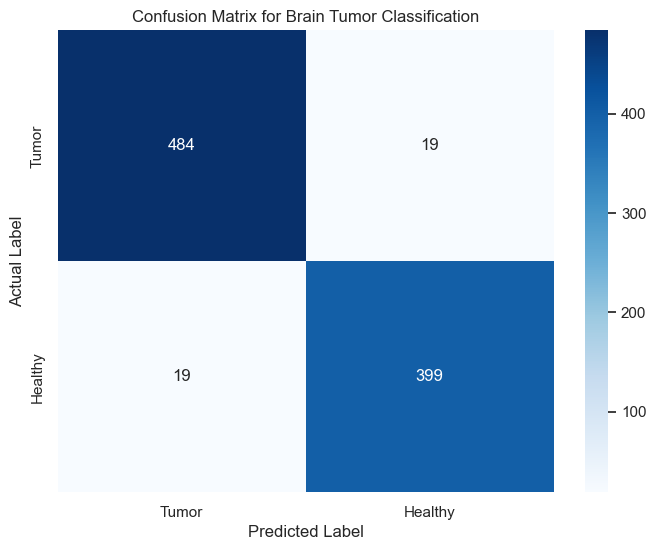

In [44]:
 def show_cm(cm, labels, title ='Confusion matrix'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

show_cm(cm, labels=['Tumor', 'Healthy'], title='Confusion Matrix for Brain Tumor Classification')

##### Overall I can see that this model was correct. It only mislabeled the data 19 times. 